In [49]:
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics.pairwise import euclidean_distances

with open('data/to_embed.json', 'r') as f: to_embed = json.load(f)
E = np.load('data/embeddings.npy')
centroids = np.load('data/centroids.npy')
curr_E = np.load('data/current_embs.npy')

def softmax(x):
    e = (np.exp(x) - np.max(x, axis = 1, keepdims = True))
    e /= e.sum(axis = 1, keepdims = True)
    return e

I am currently a grad student at the University of Michigan and like to attend seminars, lectures, and social events when I can. However, I often attend the same weekly seminar or other recurring events because sifting through all events (588 this week) to find ones that interest me is very time-consuming. Last semester, I tried feeding the events to ChatGPT and [asking for recommendations](https://emiliocantuc.github.io/umich-events-gpt/), but they were not great.


So, given it's fall break, I want to hack into a simple recommender system to do a better job. The goal is to get to an MVP that other students can use this weekend and iterate on it during the semester. Let's see what we can come up with.

# Overview

I want to keep the recommender and overall system as simple as possible. We'll start with content-based filtering, where users are recommended similar events to ones they have previously enjoyed. To do so, we need a way for users to give feedback on events and a way of determining how similar two events are.

For feedback, we can allow users to downvote, upvote, and add an event to their calendar (in which case they are interested and plan on actually attending):

![](images/card_example.png){width=300 fig-align="center"}

For similarity, we can simply represent our events as strings, obtain their [embeddings](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526), and use the cosine distance between events. To keep things simple (and affordable), we can just use OpenAI's [API](https://platform.openai.com/docs/guides/embeddings).

Because I'd like to implement changes quickly and don't expect more than a handful of users, we'll use Python, Flask, and SQLite. Let's jump in.

# Data

The university's event page, [Happening @ Michigan](https://events.umich.edu/) is great. It provides openly available endpoints to fetch events with all of their details in JSON format. Great! No scrapping is necessary. We can simply fetch the events of the day or week to keep the system up-to-date.

# Embeddings

One of the biggest challenges (as far as I can tell) in recommender systems is coming up with vector representations of the items (movies, products, events, etc.) such that distances between are semantically meaningful. Luckily, it's now very easy and convenient to throw items to a neural network and get such embeddings.  

First, let's take a look at three events and how we might represent them as strings:

In [24]:
for e in [69, 70, 71]: print(f'{"="*50}\n{to_embed[e]}')

Careers / Jobs:Workshop: UROP Resume Review Open House at The Career Center
UROP students are welcome to drop in for resume reviews, as they prepare to apply for upcoming research projects.  Career Center staff and UROP Peer Advisors will be on hand to answer application and resume questions.
Where:The Career Center
When:Friday 12
Sponsors:University Career Center
Careers / Jobs:Workshop: Freshman Friday
Join us on Fridays from 12-1:00 for FREE FOOD and fun staff!  Meet The Career Center Advisors in an informal setting.
Where:The Career Center
When:Friday 12
Sponsors:University Career Center
Careers / Jobs:Workshop: UROP Resume Workshop
This is a closed resume workshop for students in the UROP program.
Where:The Career Center
When:Friday 11
Sponsors:University Career Center


We include the event type before the title, the description (truncated to about 200 characters), the location name and date, and sponsoring groups. Note that we only include the day of the week and the start hour in the date to make it easier for the text model to make sense of. For now, we'll use OpenAI's `text-embedding-3-small` model, but we can try others later.

We now have a 1536-dimentional vector representing each event and can use dot products to determine similarity. For example, For the events above, we have:

In [27]:
(E[[69, 70, 71]] @ E[[69, 70, 71]].T)[0]

array([0.99999999, 0.64823593, 0.89352812])

which makes sense since the first event is most similar to itself and then to the other resume workshop.

# KNN recommender

If we encode downvotes as `-1`, upvotes as `1` and "adds to calendar" as `2`, we could implement a very simple recommender. Given a user and a new event, look up the event's k-nearest neighbors (using embeddings and dot products) with ratings by the user and return the average rating. This average rating can be considered the estimated rating the user would give to the new event.  Repeat for each new event and return events with the highest predicted ratings.

This system would be fairly simple to spin up, and we could even keep the KNN lookup constant by using approximate methods like those provided in `faiss` or any of the many vector databases.

However, we still have to keep around a growing list of past events (at least their embeddings) and user ratings. To avoid running out of a cheap VM's disk space (being very, very optimistic about user count), we could prune the oldest ratings once in a while or come up with some other simple scheme. But I wanted to try something else out.

# Clustering: constant storage?

What if we ...

- cluster a bunch of past events and obtain their centroids
- have users somehow rate clusters
- can estimate a new event's rating by their distance to different centroids

Then it seems that we only need to maintain a user's rating of each centroid and forget the individual events they up/down vote for. I.e., once a week passes, we can delete those events from our database.

To see how this would work, we first cluster past events. We get events from the last 10 years, keep only the nonrecurring ones (about 60k), and embed them to obtain

In [28]:
E.shape

(59745, 1536)

Now use K-means to cluster them into 1,000 clusters. Why 1,000? I'm sure there are better methodologies, but for now I inspected the resulting assignments for 10, 100, 500, etc. and picked where I felt the clusters were specific enough while still having a good number of events. It's not perfect, and I'll probably come back and play with it some more.

Anyway, now we have 1,000 centroids:


In [38]:
centroids.shape

(1000, 1536)

And each of which is rated by a user. We set a user's initial ratings to be random but close to zero, to give some diversity in their recommendations when they sign up: 

In [128]:
user_ratings = np.random.uniform(-1e-5, 1e-5, 1000)
user_ratings.shape

(1000,)

Now, when we get the new events of the week, we can embed them (`curr_E`) and calculate their distances to each centroid:

In [47]:
dists_to_centroids = euclidean_distances(curr_E, centroids)
curr_E.shape, dists_to_centroids.shape

((641, 1536), (641, 1000))

How do we get the expected rating the user will give to each event? Intuitively, we would like each centroid to "have a say" in the final rating, with closer events given more priority. I.e., we'll weigh centroids inversely to their distance to the new events:

In [96]:
inv_temp = 1
cluster_weights =  1 / (dists_to_centroids + 1e-6)
cluster_weights = softmax(cluster_weights * inv_temp)

Where we use [softmax](https://en.wikipedia.org/wiki/Softmax_function) to have the weights add up to one. In addition, we can play around with the "inverse temperature" $\tau$ parameter to weigh the closest centroids more (higher $\tau$) or less (smaller $\tau$ ) heavily.

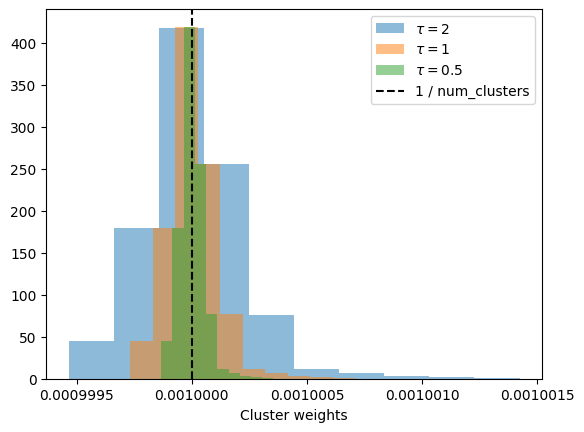

In [112]:
#| code-fold: true
#| code-summary: Playing with inv. temperature
w =  1 / (dists_to_centroids + 1e-6)
taus = [0.5, 1, 2]
for tau in reversed(taus):
    w = softmax(cluster_weights * tau)
    plt.hist(w[0], label = r'$\tau = $' + f'{tau}', alpha = 0.50)

plt.axvline(1/len(centroids), label = '1 / num_clusters', color = 'black', linestyle = '--')
plt.gca().set_xticks(plt.gca().get_xticks()[1::2])
plt.xlabel('Cluster weights')
plt.legend()

Awesome, we can now weigh each cluster. So for a new event, we can get the estimated rating by taking the weighted sum:

In [130]:
new_event_ix = 0
cluster_weights[new_event_ix] @ user_ratings

-1.3426919962571645e-07

And then recommend those new events with the highest predicted ratings:

In [165]:
n_recs = 5
pred_ratings = cluster_weights @ user_ratings
rec_ixs = np.argsort(pred_ratings)[-n_recs:]
rec_ixs

array([475,  22, 555, 554, 201])

The only thing missing is a way to update the user's ratings of centroids when they rate an event. Intuitively, once a user rates an event, we should change the entries in `user_ratings` proportionally to the weight they were given in the prediction and the difference between the predicted and actual rating. In fact, we made the prediction on event $i$ with

$$
\hat y_i(w_i, u) = w_i^\top u
$$

Where $w_i$ are the cluster weights for the event and $u$ the user's ratings of the centroids. Let $y_i$ the actual rating given by the user. We can then define our loss (with a convenient 1/2 that cancels later) as

$$
L(\hat y_i, y_i) = \frac{1}{2}(\hat y_i - y_i)^2
$$

Noting that we only want to update $u$ and not the embeddings or centroids, we can get

$$
\frac{\partial L}{\partial u} = (\hat y_i - y_i) \frac{\partial \hat y_i}{\partial u} = (\hat y_i - y_i) w_i^\top
$$

And can perform [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent):

$$
u \leftarrow u - \lambda (\hat y_i - y_i) w_i^\top
$$

Or in code:

In [169]:
# Before update
rated_ix, rating = 0, 2 # event rated and rating given
pred_ratings[rated_ix]

0.00020218347827034036

In [170]:
# Update
lr = 0.1  # step size / lambda
user_ratings -= lr * cluster_weights[rated_ix] * (pred_ratings[rated_ix] - rating)

# After update
pred_ratings = cluster_weights @ user_ratings
pred_ratings[rated_ix]

0.00040448075950620985

And that's the basics. Later on, I'll play with different optimizers that can account for sparse features, clustering algorithms, and so on. But for now, I just want to implement it. 

# Implementation

Assume we have embedded and clustered the bunch of past events and have the centroids. The basic idea is to fetch the events for the upcoming week Sundays and embed them. We then compute their distances to the centroids (or even the weights) and store them (the NumPy arrays as blobs in the db). And those are the only things we batch. 

I drew some inspiration and referenced from karpathy's [arxiv-sanity lite](https://github.com/karpathy/arxiv-sanity-lite/tree/master). For auth, I decided to go with [Signin With Google](https://developers.google.com/identity/gsi/web/guides/overview) as the university is on GSuite. Users can also join a community mailing list to get reminded weekly when recommendations are ready.  

The code is openly available [here](https://github.com/emiliocantuc/wolverine-events) and site hosted [here](https://mywolverine.events).

# A lot of room

for improvement. For example:

- Once the clusters and centroids are computed, there is no way to change them. Either make sure they are good enough so that we never have to change them or come up with something different. 
- Find a way to set parameters (learning rate, inv. temperature) in a more principled way, or test thoroughly. Should each user have their own learning rate?

And I'm sure I'll come up with others.